In [20]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq, MAT, Statistics, LinearAlgebra

In [21]:
# siControl B55=1.0, MASTL=0.1
CCNB1 = [0.24642354118893195 1.0014573560395306;
10.12780965905784 0.8874483465061871;
15.166629805957465 0.8470381450139104;
17.090293217241502 0.6940576656694878;
19.09194612904352 0.6119172612881075;
21.083821252720902 0.4832834743740473;
23.07383394056501 0.3457938050728099;
24.950703651538255 0.27030928075056193;
27.010324878650657 0.16380821567006976;
28.95680312889219 0.11931229556856682;
30.89909089850888 0.05489064009591571;
32.976870874995626 0.03473442829040052;
35.05884133210722 0.03450395185603394;
37.01416615255677 0.03207347309362252;
39.03351220477481 0.03406395139042506;
40.923884575539226 0.02278457437521131;
43.005389423692506 0.02034012734405044;
45.02520108486887 0.024544576237647053]

pMPS1 = [-0.0229312411970799 0.6206753657940381;
10.052846616768905 0.5309990804223077;
15.098185289084961 0.5215844672851508;
17.107753553178362 0.4770815630492733;
19.05330058550326 0.4281577017541821;
20.994191528244997 0.3570941344911479;
23.007484664004934 0.3303029950296247;
25.019846581848228 0.29908391437451287;
26.969118485839665 0.2678718178537757;
28.922580870455946 0.2565854567041874;
31.064847687669506 0.24306417255468027;
32.93799252697622 0.149867883458078;
34.95594175231931 0.14521644996449745;
37.03977464526417 0.15384185591730803;
38.91291948457088 0.060645566820705765;
40.93552479949713 0.07813383929506834;
42.94462745463222 0.0314169644623965;
44.89436496758197 0.002418838538453816]

pENSA = [-0.0552910638000661 0.1668044093168355;
9.986730144687984 0.21661525567751938;
14.955010534402684 0.14078850877090887;
16.968303670162612 0.11399736930938587;
18.99882433738025 0.16912314192925093;
20.886403054394762 0.14455994133327144;
22.978616908589323 0.19303681802837924;
24.926957594664124 0.15739678031405346;
27.002875135317595 0.1283846861213611;
29.01290900836932 0.08609575248227808;
31.024805317254298 0.052662701230371756;
32.905865508852386 -0.0028960877207275804;
34.99482010033872 0.030082994796820195;
37.006716409223706 -0.0033500564550861256;
38.970422190922946 0.03407093552479967;
40.923418966580904 0.020570603778417018;
42.87036282578076 -0.02171134572629141;
44.90321153778998 0.04448427987754511];

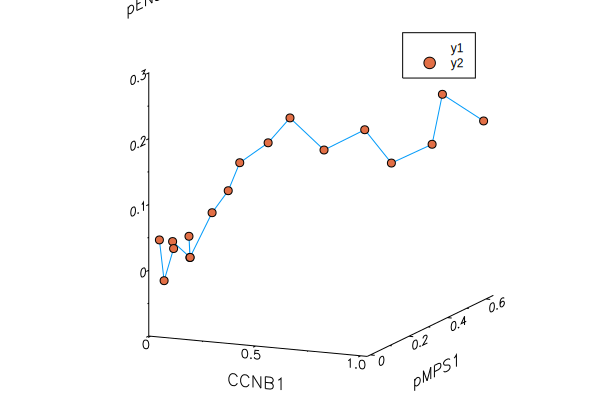

In [22]:
a = CCNB1[:,2]
b = pMPS1[:,2]
c = pENSA[:,2]

plt=plot(a,b,c, xlab = "CCNB1", ylab = "pMPS1", zlab  = "pENSA", grid = "off")
scatter!(a,b,c)

In [23]:
# Observed data
ode_data = transpose(hcat( a,b,c))
u0 = ode_data[:,1]
tspan = (0.,1.)
if(CCNB1[1]>0)
    t = CCNB1[:,1].-(CCNB1[1])
else
    t = CCNB1[:,1].+abs(CCNB1[1])
end
t = t./t[end]
species = ["CCNB1", "pMPS1", "pENSA"];u0

3-element Array{Float64,1}:
 1.0014573560395306
 0.6206753657940381
 0.1668044093168355

In [24]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()), n_epochs)
    count_epochs = 0
    return saver(losses, l2s, times, count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

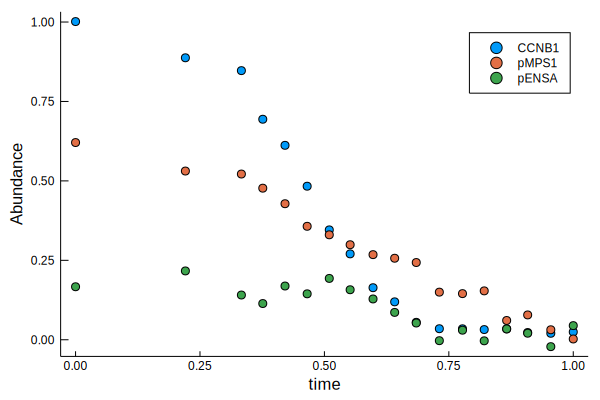

In [25]:

scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[1])
#plot!(t, ode_data[1,:], label = species[1])

scatter!(t, ode_data[2,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[2])
#plot!(t, ode_data[2,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[2])

scatter!(t, ode_data[3,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[3])
#plot!(t, ode_data[3,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[3])


In [75]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(3,80,tanh),
       Dense(80,80,tanh),
       Dense(80,80,tanh),
       Dense(80,3))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_,x,tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
# Rosenbrock23, TRBDF2, ABDF2, Rodas5, Rodas4P, Kvaerno5, KenCarp4, CVODE_BDF (not defined)
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Rosenbrock23(autodiff=false), reltol=1e-7, abstol=1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Rosenbrock23(autodiff=false), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 5000
verify = 10 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.0001)

L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()), Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0, Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end

#43 (generic function with 1 method)

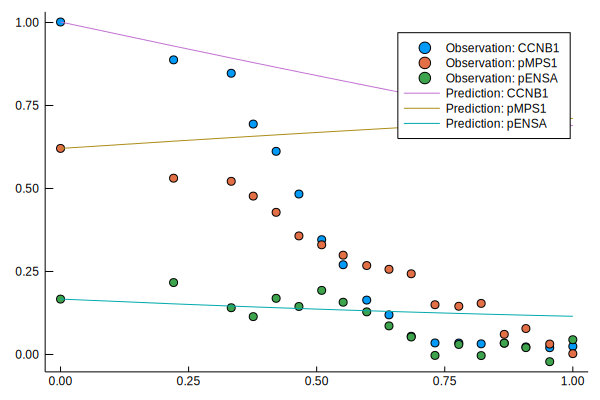

In [76]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species[1]), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species[2]), grid = "off")
scatter!(t, ode_data[3,:], label = string("Observation: ", species[3]))
#scatter!(t, ode_data[4,:], label = string("Observation: ", species4))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species[1]))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species[2]))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species[3]))
#plot!(t, Flux.data(pred[4,:]), label = string("Prediction: ", species4))

In [77]:
sa = saver(n_epochs)
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

476.291061 seconds (852.11 M allocations: 335.552 GiB, 13.38% gc time)


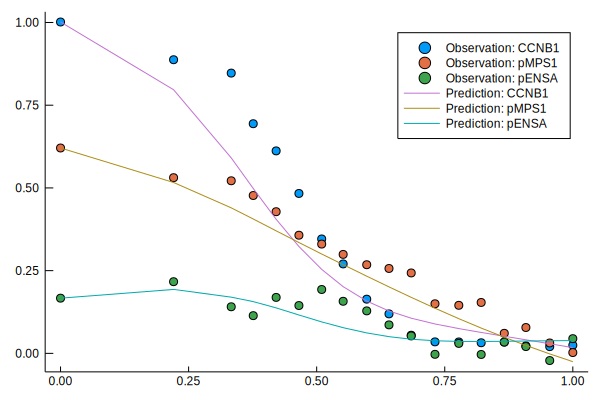

In [78]:
pred = n_ode(u0)
#scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter(t, ode_data[1,:], label = string("Observation: ", species[1]), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species[2]))
scatter!(t, ode_data[3,:], label = string("Observation: ", species[3]))
#plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species[1]))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species[2]))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species[3]))

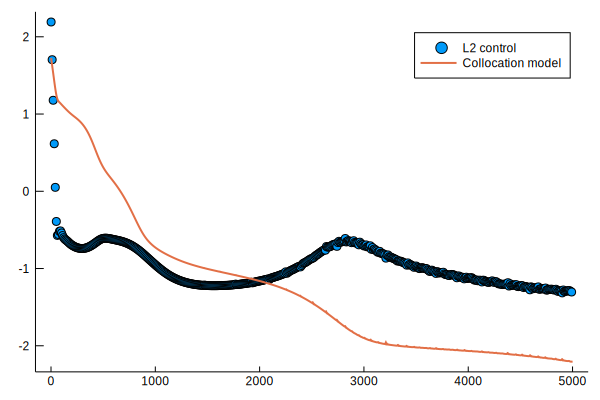

In [79]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s

In [80]:
# train n_ode with collocation method
sa = saver(n_epochs)
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

546.022322 seconds (977.12 M allocations: 387.256 GiB, 13.26% gc time)


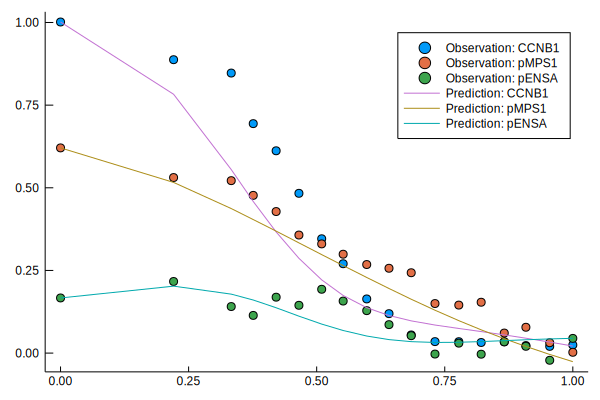

In [81]:
pred = n_ode(u0)
#scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter(t, ode_data[1,:], label = string("Observation: ", species[1]), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species[2]))
scatter!(t, ode_data[3,:], label = string("Observation: ", species[3]))
#plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species[1]))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species[2]))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species[3]))

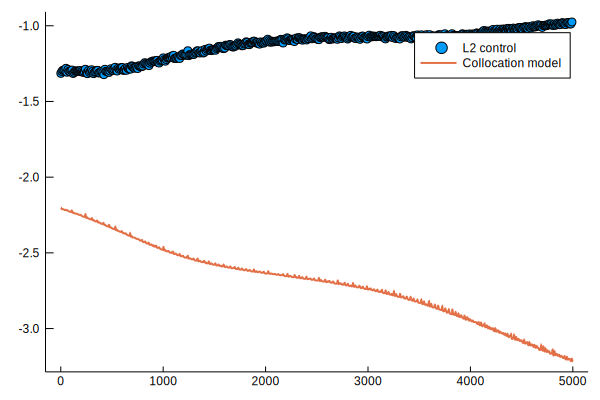

In [82]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s